In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import time
import math
import copy
import random
from matplotlib import pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv("./data_banknote_authentication.txt", header=None)
m, n = data.shape
# seperate into input and output features
X, Y = data.values[:, :-1], data.values[:, -1]
Y = LabelEncoder().fit_transform(Y)
# split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = X_train.T
X_test = X_test.T

In [4]:
def relu(Z):
    return np.maximum(Z, 0)

def tanh(Z):
    return np.tanh(Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu_deriv(Z):
    return Z > 0

def tanh_deriv(Z):
    return 1-np.tanh(Z)**2

def sigmoid_deriv(Z):
    sig = 1/(1+np.exp(-Z))
    return sig * (1 - sig)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [121]:
class NeuralNetwork:
    def __init__(self, layer_sizes, epochs, alpha, activations):
            self.layer_sizes = layer_sizes
            self.num_iters = epochs
            self.learning_rate = alpha
            self.activations = activations
            self.params = {}
            self.last = len(self.layer_sizes)
            self.init_params()
            self.accuracy = None
            self.X = None
            self.Y = None
            self.AccuracyList = []
            self.AccuracyEpochList = []
            self.AccuracyTimeList = []
            self.totalTime = None
            self.startTime = None
            self.stopTime = None
            
    def __repr__(self):
        return f"ANN Hyperparameters\nLayers: {self.layer_sizes}\nIterations: {self.num_iters} \
                \nLearning rate: {self.learning_rate}\nActivations: {self.activations}"
    
    # Initalize the network with random weights and biases
    def init_params(self):
        # Initalize the network with random weights and biases 
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i-1]) - 0.5
            params[f'B{i}'] = np.random.rand(self.layer_sizes[i],1) - 0.5

    def forward_propagation(self, X):
        # Pass X through the network 
        params = self.params
        for i in range(1, self.last):
            if i==1:
                # For first layer compute dot with x
                output = params[f'W{i}'].dot(X) + params[f'B{i}']
            else: 
                # For all other layers compute with output of prev layer
                output = params[f'W{i}'].dot(params[f'A{i-1}']) + params[f'B{i}']
          
            # For all other layers use the activ_fnc initalized in constructor
            activ_fnc = self.activations[i-1]
            activations = globals()[activ_fnc](output)
            
            params[f'Z{i}'] = output
            params[f'A{i}'] = activations


    def backward_propagation(self, X, Y):
        ohY = one_hot(Y)
        params = self.params
        
        for i in range(self.last - 1, 0, -1):
            if(i == self.last - 1):
                # For final layer calculate how wrong net is and compute gradients for weights and biases
                dZ =  params[f'A{i}'] - ohY
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            elif (i == 1):
                # For first layer compute the gradients for weights and biases with input of dataset
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(X.T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            else: 
                # For all other layers compute the gradients for weights and biases with the output of the prev layer
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)

    
    def update_params(self, alpha):
        # Update all layers based on the gradients calculated in back prop
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] =  params[f'W{i}'] - self.learning_rate * params[f'dW{i}']
            params[f'B{i}'] =  params[f'B{i}'] - self.learning_rate * params[f'dB{i}']

    def make_predictions(self, X):
        self.forward_propagation(X)
        predictions = self.get_predictions()
        return predictions

    def test_predictions(self, i):
        curr = X_train[:, i, None]
        print("label ", Y_train[i])
        print("predicted ", self.make_predictions(curr)[0])

    def get_predictions(self):
        return np.argmax(self.params[f'A{self.last-1}'], 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def train(self, X, Y, printAccuracy=False):
        start = time.perf_counter()
        self.X = X
        self.Y = Y
        for i in range(self.num_iters):
            self.forward_propagation(X)
            self.backward_propagation(X, Y)
            self.update_params(self.learning_rate)
       
            predictions = self.get_predictions()
            self.accuracy = self.get_accuracy(predictions, Y)
            self.AccuracyList.append(self.accuracy)
            self.AccuracyEpochList.append((i,self.accuracy))
            self.AccuracyTimeList.append(((time.perf_counter() - start), self.accuracy))
       
            # Print accuracy every 10 iterations
            if(printAccuracy==True):
                if i % 1 == 0:
                    print("Iteration: ", i)
                    print('Accuracy: ', self.accuracy)
        stop = time.perf_counter()
        self.totalTime = stop - start
        self.startTime = start
        self.stopTime = stop
        return self.params
     
    def change_neurons(self, layers, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.layer_sizes = layers
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")    

    def change_activations(self, activations, printChange=False, showIteration=False):
        old_accuracy = self.accuracy
        self.activations = activations
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")

    def change_epochs(self, epochs, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.num_iters = epochs
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
    
    def change_learningRate(self, alpha, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.learning_rate = alpha
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
        
    def view_accuracyEpoch(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyEpochList, columns=["Epochs", "Accuracy"])
        sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None)
    
    def view_accuracyTime(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyTimeList, columns=["Time", "Accuracy"])
        sns.lineplot(data=df, x="Time", y="Accuracy", ci=None)

In [122]:
nn = NeuralNetwork([4,10,10,2], 500, 0.10, ['relu','relu','sigmoid'])

In [123]:
x = nn.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.45416666666666666
Iteration:  1
Accuracy:  0.48333333333333334
Iteration:  2
Accuracy:  0.646875
Iteration:  3
Accuracy:  0.6520833333333333
Iteration:  4
Accuracy:  0.6947916666666667
Iteration:  5
Accuracy:  0.725
Iteration:  6
Accuracy:  0.75
Iteration:  7
Accuracy:  0.7666666666666667
Iteration:  8
Accuracy:  0.78125
Iteration:  9
Accuracy:  0.8260416666666667
Iteration:  10
Accuracy:  0.8645833333333334
Iteration:  11
Accuracy:  0.9145833333333333
Iteration:  12
Accuracy:  0.9385416666666667
Iteration:  13
Accuracy:  0.9541666666666667
Iteration:  14
Accuracy:  0.9708333333333333
Iteration:  15
Accuracy:  0.9760416666666667
Iteration:  16
Accuracy:  0.978125
Iteration:  17
Accuracy:  0.9802083333333333
Iteration:  18
Accuracy:  0.9822916666666667
Iteration:  19
Accuracy:  0.9833333333333333
Iteration:  20
Accuracy:  0.9833333333333333
Iteration:  21
Accuracy:  0.9833333333333333
Iteration:  22
Accuracy:  0.9833333333333333
Iteration:  23
Accuracy:  0.985

In [124]:
preds = nn.make_predictions(X_test)

In [125]:
nn.test_predictions(1)

label  1
predicted  1


In [126]:
nn.test_predictions(2)

label  0
predicted  0


## Hyperparameter Investigation

#### Informal Investigation

In [127]:
def compareThrice(nn, parameter, new_values):
        one = copy.deepcopy(nn)
        #one.train(nn.X, nn.Y)
    
        two = copy.deepcopy(nn)
        #two.train(nn.X, nn.Y)
        
        three = copy.deepcopy(nn)
        #three.train(nn.X, nn.Y)
        
        new_accuracy = None
        
        if (parameter == "neurons"):
            one.change_neurons(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_neurons(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_neurons(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "activations"):
            one.change_activations(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_activations(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_activations(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "epochs"):
            one.change_epochs(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_epochs(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_epochs(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "learningRate"):
            one.change_learningRate(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_learningRate(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_learningRate(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        else:
            print("Error comparing") 
        
        print(f"Original accuracy: {nn.accuracy}\nMean accuracy from three trials of different {parameter}: {new_accuracy}")

In [128]:
ann = NeuralNetwork([4,3,2,2], 100, 1, ['relu','relu','sigmoid'])

In [129]:
ann.train(X_train, Y_train, printAccuracy=False);

In [130]:
# Original Hyperparameters
ann

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

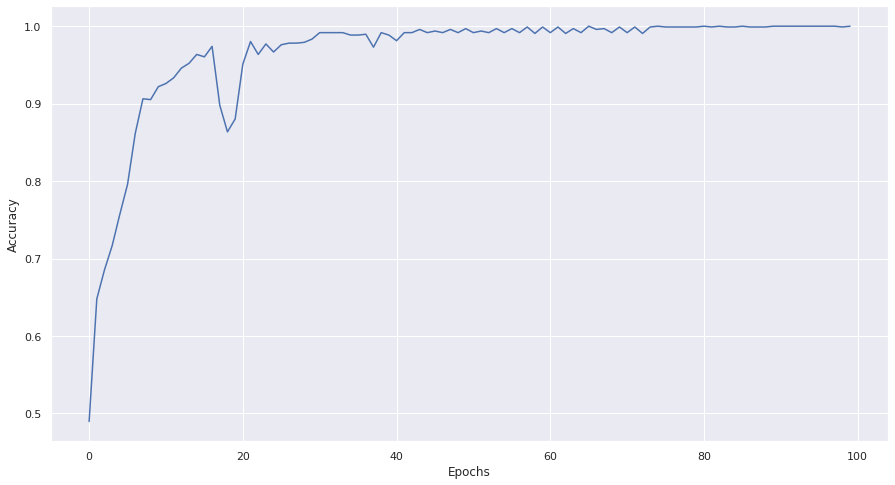

In [131]:
ann.view_accuracyEpoch()

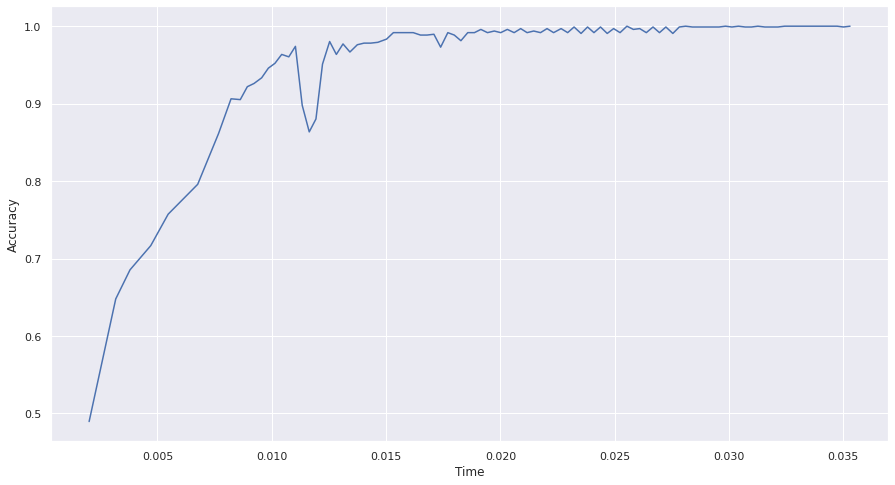

In [132]:
ann.view_accuracyTime()

In [134]:
ann

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

In [135]:
# Current Hyperparameters
annLayers

ANN Hyperparameters
Layers: [4, 8, 8, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

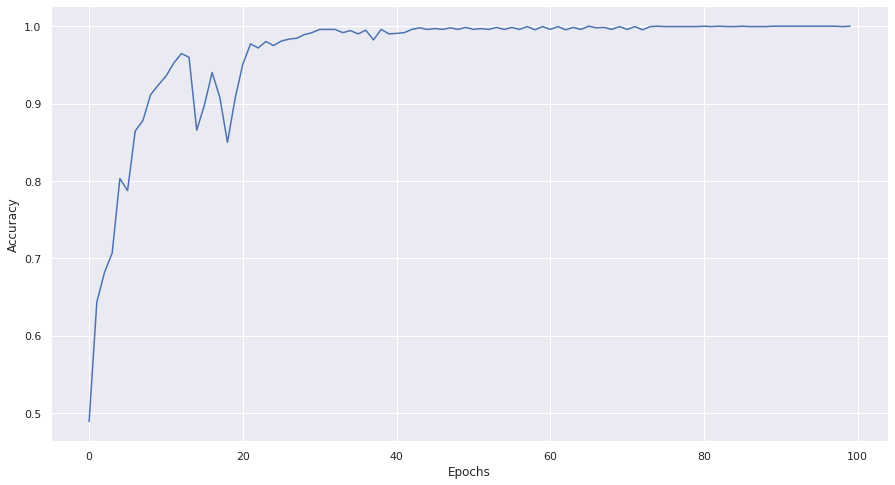

In [136]:
annLayers.view_accuracyEpoch()

In [ ]:
# large number of layers

manyLayers = copy.deepcopy(ann)
manyLayers.change_neurons([4,8,8,8,2])

In [137]:
# Change activation functions
annActs = copy.deepcopy(ann)
annActs.change_activations(['sigmoid', 'sigmoid','sigmoid'])

In [138]:
# Current Hyperparameters
annActs

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['sigmoid', 'sigmoid', 'sigmoid']

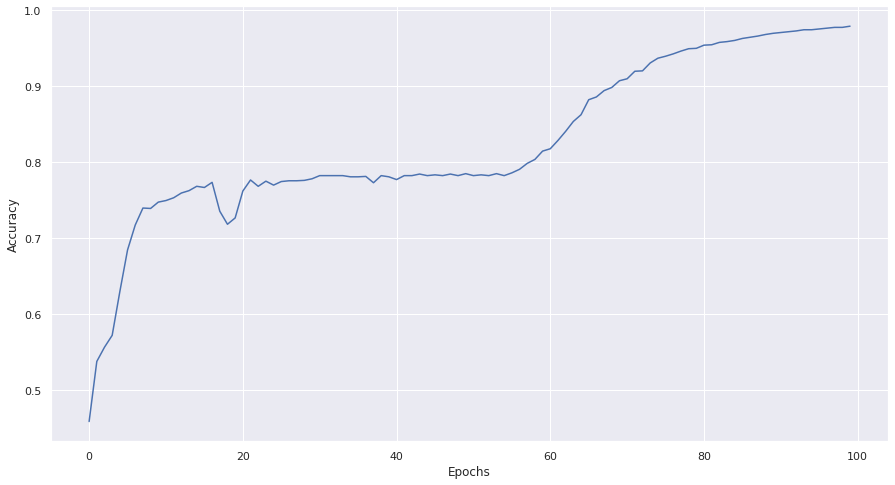

In [139]:
annActs.view_accuracyEpoch()

In [140]:
# Change Number of Iterations
annEpochs = copy.deepcopy(ann)
annEpochs.change_epochs(50)

Old test accuracy: 1.0
New test accuracy: 1.0


In [141]:
annEpochs

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 50                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

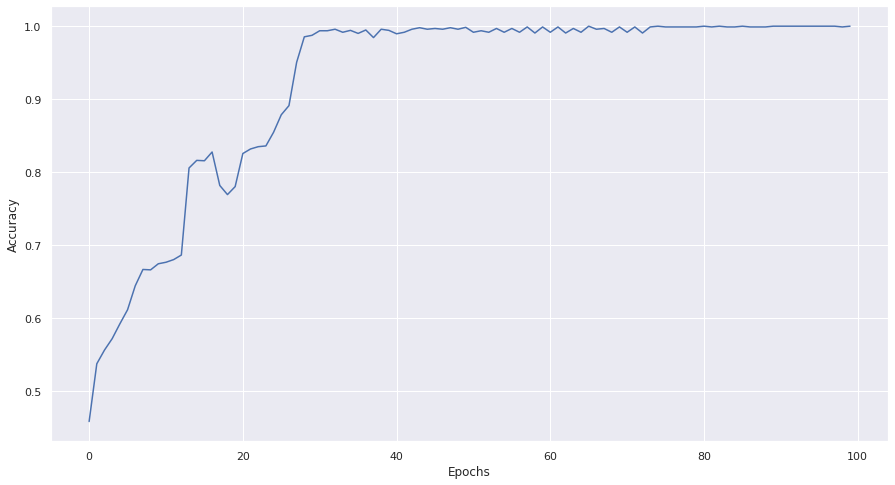

In [142]:
annEpochs.view_accuracyEpoch()

In [143]:
# Change Learning rate
annAlpha = copy.deepcopy(ann)
ann.change_learningRate(0.05)

Old test accuracy: 1.0
New test accuracy: 0.8895833333333333


In [144]:
annAlpha

ANN Hyperparameters
Layers: [4, 3, 2, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

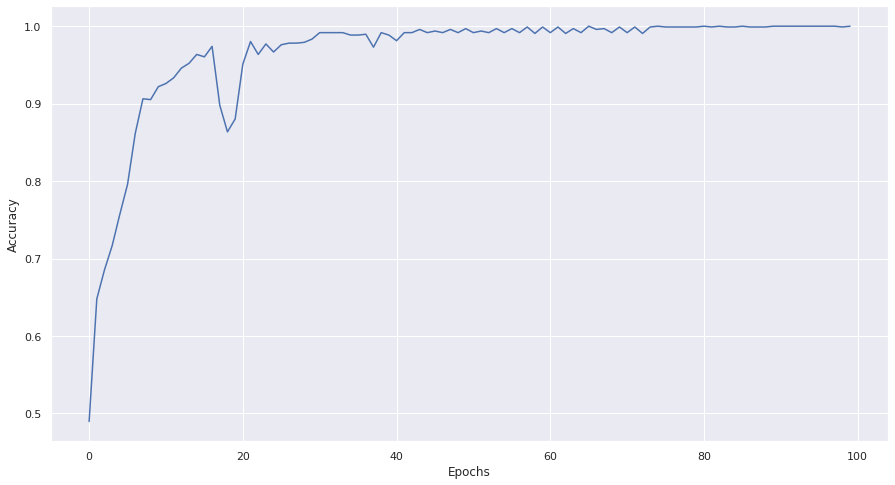

In [145]:
annAlpha.view_accuracyEpoch();

In [273]:
ann_shallow = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','sigmoid'])

In [274]:
as_output = ann_shallow.train(X_train, Y_train, printAccuracy=False)

In [288]:
ann_deep = NeuralNetwork([4,6,6,6,6,6,6,6,6,2], 100, 0.35, ['relu','relu','relu','relu','relu','relu','relu','relu','sigmoid'])

In [289]:
ad_output = ann_deep.train(X_train, Y_train, printAccuracy=False)

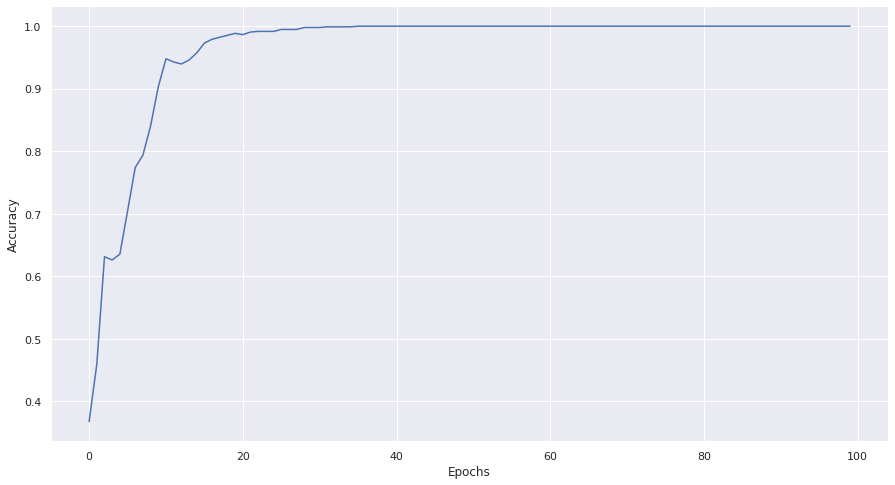

In [290]:
ann_shallow.view_accuracyEpoch();

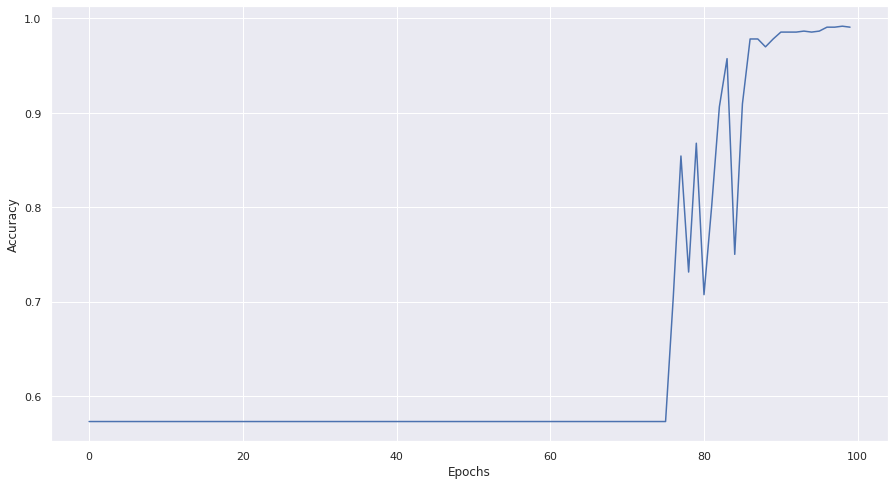

In [291]:
ann_deep.view_accuracyEpoch();

In [294]:
ann_sigmoid = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','sigmoid'])

In [297]:
sigmoid_output = ann_sigmoid.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.43854166666666666
Iteration:  1
Accuracy:  0.6916666666666667
Iteration:  2
Accuracy:  0.7125
Iteration:  3
Accuracy:  0.715625
Iteration:  4
Accuracy:  0.7260416666666667
Iteration:  5
Accuracy:  0.7489583333333333
Iteration:  6
Accuracy:  0.78125
Iteration:  7
Accuracy:  0.815625
Iteration:  8
Accuracy:  0.8510416666666667
Iteration:  9
Accuracy:  0.9083333333333333
Iteration:  10
Accuracy:  0.9447916666666667
Iteration:  11
Accuracy:  0.9614583333333333
Iteration:  12
Accuracy:  0.9729166666666667
Iteration:  13
Accuracy:  0.9833333333333333
Iteration:  14
Accuracy:  0.9864583333333333
Iteration:  15
Accuracy:  0.99375
Iteration:  16
Accuracy:  0.9947916666666666
Iteration:  17
Accuracy:  0.9958333333333333
Iteration:  18
Accuracy:  0.9989583333333333
Iteration:  19
Accuracy:  0.9989583333333333
Iteration:  20
Accuracy:  0.9989583333333333
Iteration:  21
Accuracy:  0.9989583333333333
Iteration:  22
Accuracy:  1.0
Iteration:  23
Accuracy:  1.0
Iteration:  2

In [296]:
ann_softmax = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','softmax'])

In [298]:
softmax_output = ann_softmax.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.4270833333333333
Iteration:  1
Accuracy:  0.45
Iteration:  2
Accuracy:  0.9291666666666667
Iteration:  3
Accuracy:  0.94375
Iteration:  4
Accuracy:  0.934375
Iteration:  5
Accuracy:  0.959375
Iteration:  6
Accuracy:  0.978125
Iteration:  7
Accuracy:  0.9802083333333333
Iteration:  8
Accuracy:  0.9802083333333333
Iteration:  9
Accuracy:  0.9833333333333333
Iteration:  10
Accuracy:  0.984375
Iteration:  11
Accuracy:  0.984375
Iteration:  12
Accuracy:  0.984375
Iteration:  13
Accuracy:  0.98125
Iteration:  14
Accuracy:  0.98125
Iteration:  15
Accuracy:  0.98125
Iteration:  16
Accuracy:  0.9864583333333333
Iteration:  17
Accuracy:  0.9885416666666667
Iteration:  18
Accuracy:  0.9885416666666667
Iteration:  19
Accuracy:  0.9895833333333334
Iteration:  20
Accuracy:  0.9895833333333334
Iteration:  21
Accuracy:  0.9895833333333334
Iteration:  22
Accuracy:  0.9895833333333334
Iteration:  23
Accuracy:  0.9895833333333334
Iteration:  24
Accuracy:  0.990625
Iteration:  2

In [300]:
ann_tanh = NeuralNetwork([4,6,6,2], 100, 0.35, ['tanh','tanh','sigmoid'])

In [301]:
tanh_output = ann_tanh.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.8145833333333333
Iteration:  1
Accuracy:  0.8520833333333333
Iteration:  2
Accuracy:  0.8864583333333333
Iteration:  3
Accuracy:  0.903125
Iteration:  4
Accuracy:  0.9166666666666666
Iteration:  5
Accuracy:  0.925
Iteration:  6
Accuracy:  0.9333333333333333
Iteration:  7
Accuracy:  0.9416666666666667
Iteration:  8
Accuracy:  0.946875
Iteration:  9
Accuracy:  0.9489583333333333
Iteration:  10
Accuracy:  0.9541666666666667
Iteration:  11
Accuracy:  0.9572916666666667
Iteration:  12
Accuracy:  0.9635416666666666
Iteration:  13
Accuracy:  0.9666666666666667
Iteration:  14
Accuracy:  0.9708333333333333
Iteration:  15
Accuracy:  0.975
Iteration:  16
Accuracy:  0.9770833333333333
Iteration:  17
Accuracy:  0.9833333333333333
Iteration:  18
Accuracy:  0.9833333333333333
Iteration:  19
Accuracy:  0.984375
Iteration:  20
Accuracy:  0.9875
Iteration:  21
Accuracy:  0.9875
Iteration:  22
Accuracy:  0.9885416666666667
Iteration:  23
Accuracy:  0.9885416666666667
Iteration:

In [146]:
compareThrice(ann, "neurons", [[4,5,5,2], [4,10,10,2], [4,15,15,2]])

Original accuracy: 0.8895833333333333
Mean accuracy from three trials of different neurons: 0.9923611111111111


In [147]:
compareThrice(ann, "activations", [["relu","relu","relu"], ["relu","tanh","sigmoid"], ["tanh","relu", "sigmoid"]])

Original accuracy: 0.8895833333333333
Mean accuracy from three trials of different activations: 0.8565972222222222


In [148]:
compareThrice(ann, "epochs", [20,40,60])

Original accuracy: 0.8895833333333333
Mean accuracy from three trials of different epochs: 0.7447916666666666


In [149]:
compareThrice(ann, "learningRate", [0.1,0.5,0.75])

Original accuracy: 0.8895833333333333
Mean accuracy from three trials of different learningRate: 0.9888888888888889


#### Formal

Hyperparameter values are chosen randomly within a range, performance metrics are averaged over 10 runs for each value. 

In [7]:
# trains network 10 times 
def run_ten(nn, X, Y):
    # stores run results in array
    nets = []
    for i in range(10):
        nc = copy.deepcopy(nn)
        # resets parameters every run
        nc.init_params() 
        nc.train(X, Y, printAccuracy=False)
        nets.append(nc)
    return nets

As our ANN reaches 100% accuracy, calulcating mean using the final accuracy would not be insightful as it would produce the same values. Therefore, we had to add another 
measure, which was the mean epoch at which accuracy hit 100%. This informs you which values allow ANN to converge faster. 



In [8]:
# gets mean, standard deviation, mean execution time, standard deviation execution time and number of runs that get stuck at a local minima
# across the 10 runs
def get_converg(nets):
    np_nets = np.array(nets)
    convergFilter = np.array(list(map((lambda n: n.accuracy == np.float64(1)), nets)))

    convergs = list(map((lambda n: np.where(n.AccuracyEpochList==np.float64(1))[0][1]), np_nets[convergFilter]))
    times = list(map((lambda n: np.where(n.AccuracyTimeList==np.float64(1))[0][1]), np_nets[convergFilter]))

    mean_converg = np.mean(convergs)
    std_converg = np.std(convergs)
    mean_times = np.mean(times)
    std_times = np.std(times)
    num_non_conv = len(np_nets) - len(convergFilter[convergFilter])
    
    return mean_converg, std_converg, mean_times, std_times, num_non_conv

In [9]:
# gets mean and standard deviation for accuracy 
def get_metrics(nets):
    accuracies = list(map((lambda x: x.accuracy), nets))
    mean = np.mean(accuracies)
    std = np.std(accuracies)
    return mean, std

In [10]:
test_net = NeuralNetwork([4,10,10,2], 5000, 0.49, ['relu','relu','sigmoid'])

In [11]:
# compares a specifed sample number of randomly selected learning rates within a defined range
def compareLR(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.uniform(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for lr in test_values: 
        new_net = NeuralNetwork(nn.layer_sizes, nn.num_iters, lr, nn.activations)
        ten_nets = run_ten(new_net, X_train, Y_train)
        results[lr] = get_converg(ten_nets)
        print('progress', f'{i}/{len(test_values)}')
        i+=1
    # results are sorted ascending based on mean epochs
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    print('Output format: epochs mean (standard deviation), time mean (standard deviation), num runs that did not reach 100% acc')
    for key, value in sorted_by_mean.items():
        print('lr', key, ' : ', 'epochs', round(value[0], 4), f'({round(value[1], 4)})', 'time', round(value[2], 4),  f'({round(value[3], 4)})', 'not 100%:', value[4])        


In [293]:
# comparing 10 randomly chosen learning rates from 0.000001 to 1.0 
compareLR(test_net, X_train, Y_train, 0.000001, 1.0, 10)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
Output format: epochs mean (standard deviation), time mean (standard deviation), num runs that did not reach 100% acc
lr 0.5529964084312892  :  epochs 34.2 (13.4298) time 35.2 (13.4298) not 100%: 0
lr 0.4714124641089207  :  epochs 49.3 (23.4821) time 50.3 (23.4821) not 100%: 0
lr 0.6639556385917665  :  epochs 57.5 (32.1193) time 58.5 (32.1193) not 100%: 0
lr 0.9188419798046351  :  epochs 59.875 (55.0442) time 61.0 (54.9318) not 100%: 2
lr 0.7614370057227945  :  epochs 60.0 (34.1687) time 61.0 (34.1687) not 100%: 2
lr 0.26767881636973695  :  epochs 61.5 (30.3719) time 62.5 (30.3719) not 100%: 0
lr 0.8817113472663921  :  epochs 74.1 (86.1167) time 84.1 (83.8289) not 100%: 0
lr 0.7765224593757944  :  epochs 85.3 (79.8662) time 86.3 (79.8662) not 100%: 0
lr 0.18043789615991743  :  epochs 98.6 (63.1288) time 99.6 (63.1288) not 100%: 0
lr 0.267239160805

In [13]:
# compares a specifed sample number for randomly selected number of hidden layers within a defined range
def compareLayers(nn, X, Y, lower, upper):
    test_values = range(lower, upper) 
    results = {}
    
    for nl in test_values: 
        activations = list(map(lambda x: 'relu', range(nl)))
        activations.append('sigmoid')
        
        layers = list(map(lambda x: 10, range(nl)))
        layers.append(nn.layer_sizes[len(nn.layer_sizes) - 1])
        layers.insert(0, nn.layer_sizes[0])

        new_net = NeuralNetwork(layers, nn.num_iters, nn.learning_rate, activations)
        ten_nets = run_ten(new_net, X_train, Y_train)
        
        results[nl] = get_converg(ten_nets)
        
        print('progress', f'{nl}/{len(test_values)}')
        
    # results are sorted ascending based on mean epochs   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    print('Output format: epochs mean (standard deviation) time mean (standard deviation)')
    for key, value in sorted_by_mean.items():
        print('lr', key, ' : ', 'epochs',round(value[0], 4), f'({round(value[1], 4)})', 'time', round(value[2], 4),  f'({round(value[3], 4)})', 'not 100%:', value[4])        


In [48]:
# comparing 10 randomly chosen number of hidden layers from 1 to 10 
compareLayers(test_net, X_train, Y_train, 1, 10)

progress 1/9
progress 2/9
progress 3/9
progress 4/9
progress 5/9
progress 6/9
progress 7/9
progress 8/9
progress 9/9
Output format: epochs mean (standard deviation) time mean (standard deviation)
lr 3  :  epochs 28.2 (14.7296) time 32.0 (16.9234) not 100%: 0
lr 4  :  epochs 54.6 (36.0727) time 55.7 (36.0168) not 100%: 0
lr 2  :  epochs 57.3 (25.842) time 58.3 (25.842) not 100%: 0
lr 8  :  epochs 59.5 (24.2487) time 60.625 (24.1502) not 100%: 2
lr 7  :  epochs 60.4 (33.5416) time 61.6 (33.927) not 100%: 5
lr 5  :  epochs 72.2857 (33.2596) time 73.2857 (33.2596) not 100%: 3
lr 6  :  epochs 74.75 (62.8485) time 78.0 (64.7978) not 100%: 2
lr 1  :  epochs 271.6 (533.4621) time 272.7 (533.7612) not 100%: 0
lr 9  :  epochs 723.8 (1319.4851) time 939.2 (1748.1907) not 100%: 5
